In [3]:
# train_rl_pricing.py

End-to-end RL training script for surge-multiplier selection.

- Environment state: [demand, supply, competitor_price, base_price]
- Action: continuous multiplier in [min_multiplier, max_multiplier]
- Reward: as in the LaTeX specification:
    R = α * max(0, (R_ride - R_target)/R_target)
      + β * max(0, D - D_target)
      - δ * max(0, D_target - D)
      + η * MS
  where MS = exp(-λ*(P_ours - P_comp))

import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gym
from gym import spaces
import warnings
warnings.filterwarnings("ignore")

# Stable-baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# statsmodels / sklearn for lambda estimation
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,6)


DATA_PATH = "DRL_project_data.xlsx"   # your file path (csv or xlsx)
OUTPUT_DIR = Path("rl_pricing_output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# RL / env hyperparams
MIN_MULTIPLIER = 0.7
MAX_MULTIPLIER = 2.0
SIMULATION_LENGTH = 168    # episode length (hours) -- used if you simulate sequences
DEMAND_NOISE = 0.0         # optional noise to simulate stochasticity in env

# Reward weights (tune)
ALPHA = 10.0   # revenue term
BETA  = 5.0    # utilization positive term
DELTA = 5.0    # utilization negative term
ETA   = 3.0    # market share term

D_TARGET = 0.70
RPR_TARGET_MULT = 1.12   # R_target = 1.12 * baseline

# Training config
TOTAL_TIMESTEPS = 100_000   # reduce if you are testing locally
PPO_POLICY = "MlpPolicy"

SEED = 42
np.random.seed(SEED)

def load_data(path):
    path = str(path)
    if path.lower().endswith((".xls",".xlsx")):
        df = pd.read_excel(path)
    else:
        df = pd.read_csv(path)
    return df

df_raw = load_data(DATA_PATH)
print(f"[info] loaded {len(df_raw)} rows from {DATA_PATH}")

# Normalize column names that vary (robust mapping)
colmap = {c.lower(): c for c in df_raw.columns}
lower_cols = {c.lower(): c for c in df_raw.columns}
def col(name):
    # attempts to map common alternatives to the actual column name
    n = name.lower()
    if n in lower_cols: return lower_cols[n]
    # some alternatives
    alt = {
        "competitor price":"competitor_price",
        "competitor_price":"competitor_price",
        "competitor multiplier":"competitor_multiplier",
        "competitor_multiplier":"competitor_multiplier",
        "current_price_multiplier":"current_price_multiplier",
        "current price multiplier":"current_price_multiplier",
        "base_price":"base_price",
        "base price":"base_price",
        "demand":"demand",
        "supply":"supply",
        "rides_completed":"rides_completed",
        "revenue":"revenue",
        "driver_utilization":"driver_utilization",
    }
    if n in alt and alt[n] in lower_cols:
        return lower_cols[alt[n]]
    # fallback try exact
    return name if name in df_raw.columns else None

# required columns - try to identify
req = {
    "Demand": col("Demand") or col("demand"),
    "Supply": col("Supply") or col("supply"),
    "Base_Price": col("Base_Price") or col("base_price"),
    "Rides_Completed": col("Rides_Completed") or col("rides_completed"),
    "Revenue": col("Revenue") or col("revenue"),
    "Driver_Utilization": col("Driver_Utilization") or col("driver_utilization"),
}
# competitor: prefer multiplier, else price column
competitor_mult_col = None
for candidate in ["Competitor_Multiplier","competitor_multiplier","Competitor Multiplier","Competitor Price","competitor_price","Competitor_Price"]:
    if col(candidate) in df_raw.columns:
        competitor_mult_col = col(candidate)
        break

if competitor_mult_col is None:
    # try to infer competitor multiplier from competitor price & base price
    if col("Competitor_Price") in df_raw.columns and req["Base_Price"] is not None:
        df_raw["Competitor_Multiplier"] = df_raw[col("Competitor_Price")] / df_raw[req["Base_Price"]]
        competitor_mult_col = "Competitor_Multiplier"
    else:
        # fall back to 1.0
        df_raw["Competitor_Multiplier"] = 1.0
        competitor_mult_col = "Competitor_Multiplier"

# sanity check required columns exist
missing = [k for k,v in req.items() if v not in df_raw.columns or v is None]
if missing:
    raise ValueError(f"Missing required columns in dataset: {missing}")

# create working df with required numeric fields
df = pd.DataFrame()
df["Demand"] = df_raw[req["Demand"]].astype(float).clip(lower=0.0)
df["Supply"] = df_raw[req["Supply"]].astype(float).clip(lower=0.0)
df["Base_Price"] = df_raw[req["Base_Price"]].astype(float)
df["Rides_Completed"] = df_raw[req["Rides_Completed"]].astype(float).clip(lower=0.0)
df["Revenue"] = df_raw[req["Revenue"]].astype(float)
df["Driver_Utilization"] = (df_raw[req["Driver_Utilization"]].astype(float)
                            if req["Driver_Utilization"] in df_raw.columns else (df["Rides_Completed"] / df["Supply"]).fillna(0.0).clip(0,1))
df["Competitor_Multiplier"] = df_raw[competitor_mult_col].astype(float) if competitor_mult_col in df_raw.columns else 1.0

# drop NaNs rows in core cols
df = df.dropna(subset=["Demand","Supply","Base_Price","Rides_Completed","Revenue","Competitor_Multiplier"])
n_rows = len(df)
print(f"[info] prepared dataframe rows: {n_rows}")


mask = df["Rides_Completed"] > 0
if mask.sum() == 0:
    BASELINE_REV_PER_RIDE = df["Base_Price"].mean()  # fallback guess
else:
    BASELINE_REV_PER_RIDE = float((df.loc[mask,"Revenue"] / df.loc[mask,"Rides_Completed"]).mean())
R_TARGET = RPR_TARGET_MULT * BASELINE_REV_PER_RIDE

def estimate_lambda(dataframe, min_samples=50):
    tmp = dataframe.copy()
    tmp["P_ours_hist"] = tmp["Base_Price"] * tmp.get(col("Current_Price_Multiplier"), tmp.get("Current_Price_Multiplier", 1.0))
    tmp["P_comp"] = tmp["Base_Price"] * tmp["Competitor_Multiplier"]
    tmp["Demand_safe"] = tmp["Demand"].clip(lower=1.0)
    tmp["MS_obs"] = (tmp["Rides_Completed"] / tmp["Demand_safe"]).clip(lower=1e-6)
    tmp["diff"] = tmp["P_ours_hist"] - tmp["P_comp"]
    valid = tmp[(tmp["MS_obs"] > 0) & np.isfinite(tmp["diff"])]
    if len(valid) < min_samples:
        return 0.015
    X = valid["diff"].values
    y = np.log(valid["MS_obs"].values)
    X1 = np.vstack([np.ones_like(X), X]).T
    beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
    slope = beta[1]
    lam = -slope
    lam = float(np.clip(lam, 0.001, 1.0))
    return lam

LAMBDA = estimate_lambda(df)
print(f"[info] baseline_rev_per_ride={BASELINE_REV_PER_RIDE:.2f}, target={R_TARGET:.2f}, lambda={LAMBDA:.4f}")


class RideSharingPricingEnv(gym.Env):
    """A simple contextual bandit / one-step MDP per row environment.
       Each episode samples rows from dataset sequentially (or randomly).
       Observation: vector [demand_norm, supply_norm, comp_price_norm, base_price_norm]
       Action: continuous multiplier (Box(1,)) clipped to [min_mul, max_mul]
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, df, min_mul=MIN_MULTIPLIER, max_mul=MAX_MULTIPLIER,
                 alpha=ALPHA, beta=BETA, delta=DELTA, eta=ETA,
                 r_target=R_TARGET, d_target=D_TARGET, lam=LAMBDA,
                 episode_length=SIMULATION_LENGTH, shuffle=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.n = len(self.df)
        self.min_mul = float(min_mul)
        self.max_mul = float(max_mul)
        # normalization stats for state features
        self.state_cols = ["Demand","Supply","Competitor_Multiplier","Base_Price"]
        mat = self.df[self.state_cols].values.astype(np.float32)
        self.mean = mat.mean(axis=0)
        self.std = mat.std(axis=0) + 1e-8

        # gym spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32) #tells you the state the agent takes
        self.action_space = spaces.Box(low=np.array([self.min_mul]), high=np.array([self.max_mul]), dtype=np.float32) #action the agent picks

        # reward params
        self.alpha = float(alpha); self.beta = float(beta); self.delta = float(delta); self.eta = float(eta)
        self.r_target = float(r_target)
        self.d_target = float(d_target)
        self.lam = float(lam)
        self.episode_length = int(episode_length)
        self.shuffle = shuffle

        # bookkeeping
        self.ptr = 0
        self.t = 0

    def reset(self):
        # Optionally shuffle rows at the start of each episode
        if self.shuffle:
            self.df = self.df.sample(frac=1.0, random_state=np.random.randint(0, 2**31)).reset_index(drop=True)
        self.ptr = 0
        self.t = 0
        return self._get_obs(self.ptr)

    def _get_obs(self, idx):
        row = self.df.iloc[idx]
        s = np.array([row["Demand"], row["Supply"], row["Competitor_Multiplier"], row["Base_Price"]], dtype=np.float32)
        s_norm = (s - self.mean) / self.std
        return s_norm

    def seed(self, seed=None):
        """Compatibility shim for SB3 expecting old gym.Env.seed()."""
        self.np_random, seed = np.random.default_rng(seed), seed
        return [seed]


    def step(self, action):
        # action is an array-like with one value (multiplier)
        mul = float(np.array(action).reshape(-1)[0])
        mul = float(np.clip(mul, self.min_mul, self.max_mul))
        row = self.df.iloc[self.ptr]

        # compute prices & MS
        base = float(row["Base_Price"])
        p_ours = base * mul
        p_comp = base * float(row["Competitor_Multiplier"])
        MS = math.exp(-self.lam * (p_ours - p_comp))

        # expected rides: min(demand, supply) scaled by MS (cap to [0,1.5] to avoid explosion)
        demand = float(row["Demand"])
        supply = float(row["Supply"]) if row["Supply"] > 0 else 1.0
        expected_rides = min(demand, supply) * float(np.clip(MS, 0.2, 1.5))

        # optionally add some stochasticity
        if DEMAND_NOISE > 0:
            expected_rides = max(0.0, expected_rides + np.random.normal(scale=DEMAND_NOISE * expected_rides))

        rides = expected_rides
        revenue = rides * p_ours
        util = rides / max(1.0, supply)
        # reward terms
        if rides <= 0:
            term_rev = -1.0
            r_ride = 0.0
        else:
            r_ride = revenue / rides
            term_rev = self.alpha * max(0.0, (r_ride - self.r_target) / (self.r_target + 1e-8))

        term_util_pos = self.beta * max(0.0, util - self.d_target)
        term_util_neg = -self.delta * max(0.0, self.d_target - util)
        term_ms = self.eta * MS

        reward = float(term_rev + term_util_pos + term_util_neg + term_ms)

        # info dict for diagnostics
        info = {
            "index": int(self.ptr),
            "multiplier": mul,
            "p_ours": p_ours,
            "p_comp": p_comp,
            "MS": MS,
            "expected_rides": rides,
            "revenue": revenue,
            "utilization": util,
            "r_ride": r_ride
        }

        # increment pointer/time
        self.ptr += 1
        self.t += 1
        done = (self.ptr >= self.n) or (self.t >= self.episode_length)
        obs = self._get_obs(self.ptr % self.n) if not done else np.zeros(self.observation_space.shape, dtype=np.float32)
        return obs, reward, done, info

    def render(self, mode="human"):
        pass

def make_env():
    env = RideSharingPricingEnv(df, min_mul=MIN_MULTIPLIER, max_mul=MAX_MULTIPLIER,
                                alpha=ALPHA, beta=BETA, delta=DELTA, eta=ETA,
                                r_target=R_TARGET, d_target=D_TARGET, lam=LAMBDA,
                                episode_length=SIMULATION_LENGTH, shuffle=True)
    return env

def train_pricing_agent(total_timesteps=TOTAL_TIMESTEPS, save_path=OUTPUT_DIR / "ppo_pricing"):
    env = DummyVecEnv([make_env])
    model = PPO(PPO_POLICY, env, verbose=1, seed=SEED)
    model.learn(total_timesteps=total_timesteps)
    model.save(str(save_path))
    print(f"[info] saved model to {save_path}")
    return model

def evaluate_agent(model, env, n_episodes=20, greedy=False):
    """Run n_episodes and collect metrics per step"""
    rewards = []
    per_step_records = []
    for ep in range(n_episodes):
        obs = env.reset()
        done = False
        ep_reward = 0.0
        while not done:
            if greedy:
                # deterministic greedy action is model.predict(..., deterministic=True)
                action, _ = model.predict(obs, deterministic=True)
            else:
                action, _ = model.predict(obs, deterministic=False)
            obs, reward, done, info = env.step(action)
            ep_reward += reward
            per_step_records.append(info)
        rewards.append(ep_reward)
    rec_df = pd.DataFrame(per_step_records)
    metrics = {
        "episode_rewards": rewards,
        "mean_reward": np.mean(rewards),
        "std_reward": np.std(rewards),
        "per_step_df": rec_df
    }
    return metrics

def visualize_agent_behavior(eval_metrics, save_dir=OUTPUT_DIR / "eval_plots"):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    df_steps = eval_metrics["per_step_df"]

    # plot price multipliers over steps
    plt.figure()
    df_steps["multiplier"].astype(float).plot(alpha=0.8)
    plt.title("Chosen multipliers (evaluation steps)")
    plt.ylabel("Multiplier")
    plt.xlabel("step")
    plt.tight_layout()
    plt.savefig(save_dir / "multipliers_over_steps.png", dpi=200)
    plt.close()

    # plot expected rides and revenue over steps
    plt.figure()
    plt.plot(df_steps["expected_rides"].astype(float), label="expected_rides")
    plt.plot(df_steps["revenue"].astype(float), label="revenue")
    plt.legend()
    plt.title("Expected rides and revenue across evaluation steps")
    plt.tight_layout()
    plt.savefig(save_dir / "rides_revenue_over_steps.png", dpi=200)
    plt.close()

    # summary heatmap: avg multiplier by (demand_quantile, supply_quantile)
    df_steps["d_q"] = pd.qcut(df_steps["expected_rides"].fillna(0)+1e-8, q=5, duplicates="drop").astype(str)
    df_steps["s_q"] = pd.qcut(df_steps["multiplier"].fillna(0)+1e-8, q=5, duplicates="drop").astype(str)
    pivot = df_steps.pivot_table(values="multiplier", index="d_q", columns="s_q", aggfunc="mean")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivot, annot=False, cmap="viridis")
    plt.title("Avg multiplier by demand-quantile vs multiplier-quantile (diagnostic)")
    plt.tight_layout()
    plt.savefig(save_dir / "multiplier_heatmap.png", dpi=200)
    plt.close()

    print(f"[info] saved evaluation plots to {save_dir}")


def baseline_current_policy(env):
    """Return actions equal to historical current price multiplier from the dataset row"""
    # This helper will run a simulation returning revenue list
    obs = env.reset()
    done = False
    records = []
    while not done:
        idx = env.ptr
        # get historical multiplier: try to extract from original df_raw
        hist_mul = df_raw.iloc[idx].get(col("Current_Price_Multiplier"), None)
        if hist_mul is None:
            hist_mul = 1.0
        action = np.array([float(hist_mul)])
        obs, reward, done, info = env.step(action)
        records.append(info)
    return pd.DataFrame(records)

def baseline_constant_policy(env, multiplier=1.0):
    obs = env.reset()
    done = False
    records = []
    while not done:
        action = np.array([float(multiplier)])
        obs, reward, done, info = env.step(action)
        records.append(info)
    return pd.DataFrame(records)


if __name__ == "__main__":
    # 1) train model
    print("[main] training model...")
    model = train_pricing_agent(total_timesteps=TOTAL_TIMESTEPS)

    # 2) evaluate trained model (stochastic and greedy)
    eval_env = make_env()
    print("[main] evaluating stochastic policy...")
    eval_metrics_stoch = evaluate_agent(model, eval_env, n_episodes=5, greedy=False)
    print("[main] evaluating greedy (deterministic) policy...")
    eval_metrics_greedy = evaluate_agent(model, eval_env, n_episodes=5, greedy=True)

    # 3) baseline comparisons (current historical and constant)
    eval_env_for_baseline = make_env()
    df_baseline_current = baseline_current_policy(eval_env_for_baseline)
    eval_env_for_const = make_env()
    df_baseline_const = baseline_constant_policy(eval_env_for_const, multiplier=1.0)

    # 4) compute aggregated business metrics per policy
    def summarize_records(df_records, label):
        df_r = df_records.copy()
        avg_rpr = (df_r["revenue"] / (df_r["expected_rides"].replace(0, np.nan))).replace([np.inf,-np.inf], np.nan).mean()
        avg_util = df_r["utilization"].mean()
        avg_revenue_step = df_r["revenue"].mean()
        avg_rides_step = df_r["expected_rides"].mean()
        return {
            "strategy": label,
            "avg_rpr": float(np.nanmean(avg_rpr)),
            "avg_util": float(avg_util),
            "avg_revenue_step": float(avg_revenue_step),
            "avg_rides_step": float(avg_rides_step)
        }

    rec_rl = eval_metrics_greedy["per_step_df"]
    rec_curr = df_baseline_current
    rec_const = df_baseline_const

    summary = pd.DataFrame([
        summarize_records(rec_curr, "Current"),
        summarize_records(rec_const, "Constant (1.0x)"),
        summarize_records(rec_rl, "RL-Greedy")
    ])
    print("\n=== Policy summary ===")
    print(summary)

    # 5) save outputs
    rec_rl.to_csv(OUTPUT_DIR / "eval_rl_greedy_steps.csv", index=False)
    rec_curr.to_csv(OUTPUT_DIR / "eval_current_policy_steps.csv", index=False)
    summary.to_csv(OUTPUT_DIR / "policy_summary.csv", index=False)
    print(f"[info] saved eval CSVs to {OUTPUT_DIR}")

    # 6) visualizations
    visualize_agent_behavior(eval_metrics_greedy, save_dir=OUTPUT_DIR / "eval_plots")

    print("Done.")


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


[info] loaded 8640 rows from DRL_project_data.xlsx
[info] prepared dataframe rows: 8640
[info] baseline_rev_per_ride=19.62, target=21.98, lambda=0.0010
[main] training model...
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5640 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 3592        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004166398 |
|    clip_fraction        | 0.0346      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.00031     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.84e+03    |
|    n_u

Evaluating strategies over dataset (this may take a few seconds)...

Summary (per-step proxy averages):


,mean_revenue,std_revenue,mean_rpr,mean_util,pct_meet_rpr_target,pct_meet_util_target,avg_multiplier
strategy,,,,,,,
Constant,247.2160,139.4191,17.2727,0.9108,0.0000,87.6157,1.0000
Current,283.8093,174.1477,19.5600,0.9085,22.1991,87.6157,1.1314
RL-Agent,335.1181,186.0401,23.6385,0.9050,71.2384,87.2222,1.3695



Paired test: RL vs Current (Revenue)
  mean_diff: 51.308803694781275
  t_two: 60.23897142652073
  p_two: 0.0
  t_gt: 60.23897142652073
  p_gt: 0.0
  ci_lo: 49.64608238306436
  ci_hi: 52.93931888423728

Paired test: RL vs Constant (Revenue)
  mean_diff: 87.9020916402475
  t_two: 139.57723684608126
  p_two: 0.0
  t_gt: 139.57723684608126
  p_gt: 0.0
  ci_lo: 86.7260753439925
  ci_hi: 89.10979230568053

Saved detailed results to rl_output/strategy_comparison_detailed.xlsx


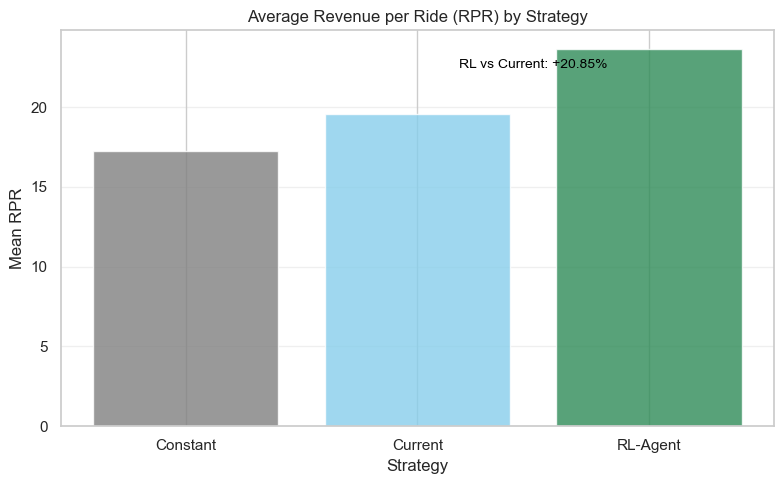

RPR Improvement (RL vs Current): +20.85%


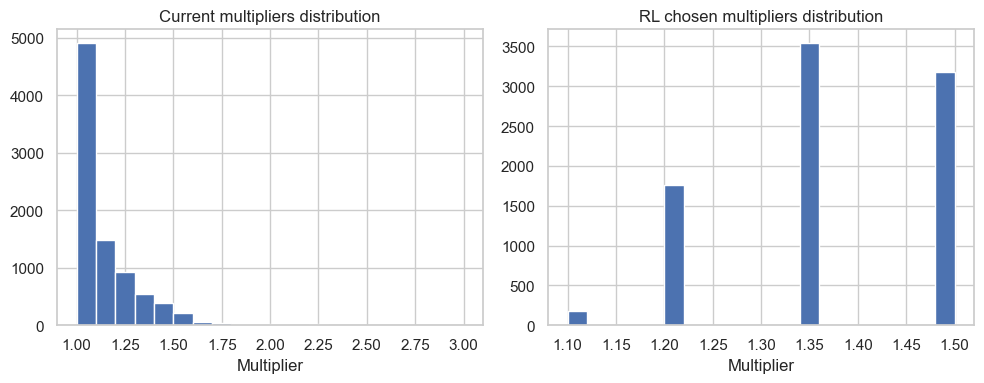


--- Quick actionable summary ---
Mean revenue (Current) : 283.81
Mean revenue (RL-Agent): 335.12
Mean revenue (Constant): 247.22
Percent change RL vs Current (proxy): 20.85%
Saved outputs and plots to: rl_output


In [10]:
 # === Strategy comparison (Constant vs Current vs RL-Agent)
# Assumes you have in memory:
# - df (pandas DataFrame with required columns)
# - ACTIONS (np.array of multipliers)  -- optional here
# - W, b (learned linear policy parameters)
# - get_state(i), policy_probs(S_batch,W,b), compute_reward_from_row(row, chosen_multiplier, ...)
# - LAM (price sensitivity)
# If any of these are missing, load the earlier script or let me know.

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
OUTPUT_DIR = "rl_output"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- helper: greedy action from linear policy parameters W,b
def greedy_action_from_policy_row(i, W, b):
    s = get_state(i)  # normalized (state_dim,)
    probs = policy_probs(s.reshape(1, -1), W, b)[0]
    a = float(ACTIONS[np.argmax(probs)])
    return a, probs

# --- helper: simulate one row given multiplier (returns rides, revenue, util, rpr, MS)
def simulate_row_with_multiplier(row, multiplier, lam=LAM):
    base = float(row['Base_Price'])
    comp_mult = float(row['Competitor_Multiplier'])
    demand = float(row['Demand'])
    supply = float(row['Supply'])
    P_ours = base * multiplier
    P_comp = base * comp_mult
    MS = float(np.exp(-lam * (P_ours - P_comp)))
    # expected rides: clip MS to avoid extreme values (same as training/eval code)
    expected_rides = min(demand, supply) * float(np.clip(MS, 0.3, 1.5))
    rides = max(0.0, expected_rides)
    revenue = rides * P_ours
    util = rides / max(1.0, supply)
    rpr = (revenue / rides) if rides > 0 else 0.0
    return {'Rides': rides, 'Revenue': revenue, 'Util': util, 'RPR': rpr, 'MS': MS, 'OurPrice': P_ours, 'CompPrice': P_comp}

# --- evaluate strategy function that takes a function(row_index) -> multiplier
def evaluate_strategy_over_dataset(multiplier_fn, df):
    results = []
    for i, row in df.iterrows():
        mult = float(multiplier_fn(i))
        sim = simulate_row_with_multiplier(row, mult)
        # compute reward using same reward function if desired:
        reward = compute_reward_from_row(row, mult)
        results.append({
            'idx': i,
            'multiplier': mult,
            'rides': sim['Rides'],
            'revenue': sim['Revenue'],
            'util': sim['Util'],
            'rpr': sim['RPR'],
            'ms': sim['MS'],
            'our_price': sim['OurPrice'],
            'comp_price': sim['CompPrice'],
            'reward': reward
        })
    return pd.DataFrame(results)

# --- Strategy definitions
def constant_multiplier_fn_factory(c=1.0):
    return lambda i: c

def current_multiplier_fn_factory(df):
    return lambda i: float(df.loc[i, 'Current_Price_Multiplier'])

def rl_multiplier_fn_factory(W, b):
    def func(i):
        # greedily select argmax action
        s = get_state(i).reshape(1, -1)
        p = policy_probs(s, W, b)[0]
        return float(ACTIONS[np.argmax(p)])
    return func

# Create functions
const_fn = constant_multiplier_fn_factory(1.0)
current_fn = current_multiplier_fn_factory(df)
rl_fn = rl_multiplier_fn_factory(W, b)

# Evaluate each strategy
print("Evaluating strategies over dataset (this may take a few seconds)...")
df_const = evaluate_strategy_over_dataset(const_fn, df)
df_current = evaluate_strategy_over_dataset(current_fn, df)
df_rl = evaluate_strategy_over_dataset(rl_fn, df)

# Summarize
def summarize_df(df_res, name):
    return {
        'strategy': name,
        'mean_revenue': df_res['revenue'].mean(),
        'std_revenue': df_res['revenue'].std(),
        'mean_rpr': df_res['rpr'].mean(),
        'mean_util': df_res['util'].mean(),
        'pct_meet_rpr_target': 100.0 * (df_res['rpr'] >= R_TARGET).sum() / len(df_res),
        'pct_meet_util_target': 100.0 * (df_res['util'] >= TARGET_UTIL).sum() / len(df_res),
        'avg_multiplier': df_res['multiplier'].mean()
    }

summary_const = summarize_df(df_const, 'Constant')
summary_current = summarize_df(df_current, 'Current')
summary_rl = summarize_df(df_rl, 'RL-Agent')

summary_df = pd.DataFrame([summary_const, summary_current, summary_rl]).set_index('strategy')
print("\nSummary (per-step proxy averages):")
display(summary_df.round(4))

# --- Paired statistical tests
# We'll compare RL vs Current, and RL vs Constant using revenue per row and reward per row.
def paired_test_and_bootstrap(x, y, n_boot=2000, seed=SEED):
    # paired t-test (two-sided and greater)
    t_stat_two, p_two = stats.ttest_rel(x, y)
    t_stat_gt, p_gt = stats.ttest_rel(x, y, alternative='greater')  # RL > baseline
    mean_diff = np.mean(x - y)
    # bootstrap 95% CI for mean diff
    rng_local = np.random.default_rng(seed)
    diffs = x - y
    m = len(diffs)
    boot_means = []
    for _ in range(n_boot):
        idx = rng_local.integers(0, m, m)
        boot_means.append(np.mean(diffs[idx]))
    lo, hi = np.percentile(boot_means, [2.5, 97.5])
    return {'mean_diff': mean_diff, 't_two': t_stat_two, 'p_two': p_two, 't_gt': t_stat_gt, 'p_gt': p_gt, 'ci_lo': lo, 'ci_hi': hi}

# Revenue comparisons (arrays aligned by row index)
rev_rl = df_rl['revenue'].values
rev_current = df_current['revenue'].values
rev_const = df_const['revenue'].values

res_rl_vs_current_rev = paired_test_and_bootstrap(rev_rl, rev_current)
res_rl_vs_const_rev = paired_test_and_bootstrap(rev_rl, rev_const)

# Reward comparisons (optional)
rew_rl = df_rl['reward'].values
rew_current = df_current['reward'].values
rew_const = df_const['reward'].values

res_rl_vs_current_rew = paired_test_and_bootstrap(rew_rl, rew_current)
res_rl_vs_const_rew = paired_test_and_bootstrap(rew_rl, rew_const)

print("\nPaired test: RL vs Current (Revenue)")
for k,v in res_rl_vs_current_rev.items():
    print(f"  {k}: {v}")
print("\nPaired test: RL vs Constant (Revenue)")
for k,v in res_rl_vs_const_rev.items():
    print(f"  {k}: {v}")

# --- Save detailed per-row comparisons to Excel for inspection
out_path = os.path.join(OUTPUT_DIR, "strategy_comparison_detailed.xlsx")
with pd.ExcelWriter(out_path) as writer:
    df_const.to_excel(writer, sheet_name='Constant', index=False)
    df_current.to_excel(writer, sheet_name='Current', index=False)
    df_rl.to_excel(writer, sheet_name='RL_Agent', index=False)
    summary_df.to_excel(writer, sheet_name='Summary')
print(f"\nSaved detailed results to {out_path}")

# --- Plot comparison bar chart (mean Revenue per Ride)
plot_df = summary_df.reset_index()

plt.figure(figsize=(8,5))
bars = plt.bar(plot_df['strategy'], plot_df['mean_rpr'], color=['gray','skyblue','seagreen'], alpha=0.8)
plt.title('Average Revenue per Ride (RPR) by Strategy')
plt.ylabel('Mean RPR')
plt.xlabel('Strategy')

# annotate percent change vs current for RL
current_rpr = summary_df.loc['Current', 'mean_rpr']
rl_rpr = summary_df.loc['RL-Agent', 'mean_rpr']
pct_change_rpr = (rl_rpr - current_rpr) / (current_rpr + 1e-8) * 100
plt.text(1.5, max(plot_df['mean_rpr'])*0.95,
         f'RL vs Current: +{pct_change_rpr:.2f}%', ha='center', fontsize=10, color='black')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "strategy_rpr_comparison.png"), dpi=300)
plt.show()

print(f"RPR Improvement (RL vs Current): +{pct_change_rpr:.2f}%")


# --- Also show distribution of multipliers chosen by RL vs Current
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
pd.Series(df_current['multiplier']).hist(bins=20)
plt.title('Current multipliers distribution')
plt.xlabel('Multiplier')
plt.subplot(1,2,2)
pd.Series(df_rl['multiplier']).hist(bins=20)
plt.title('RL chosen multipliers distribution')
plt.xlabel('Multiplier')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "multiplier_distributions.png"), dpi=300)
plt.show()

# Print quick actionable summary
print("\n--- Quick actionable summary ---")
print("Mean revenue (Current) : {:.2f}".format(summary_current['mean_revenue']))
print("Mean revenue (RL-Agent): {:.2f}".format(summary_rl['mean_revenue']))
print("Mean revenue (Constant): {:.2f}".format(summary_const['mean_revenue']))
print("Percent change RL vs Current (proxy): {:.2f}%".format(pct_change_rpr))
print("Saved outputs and plots to:", OUTPUT_DIR)
